In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sc2ts
import nb_utils

In [2]:
data_dir = Path("../data")

In [3]:
ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

In [4]:
recomb_file = data_dir / "recombinants.csv"
recomb_df = pd.read_csv(recomb_file, parse_dates=["date_added", "date_tsdate"])
len(recomb_df)

929

In [5]:
df_hq = recomb_df[recomb_df.net_min_supporting_loci_lft_rgt_ge_4].reset_index(drop=True)
len(df_hq)

386

In [6]:
time_diffs = np.zeros(len(df_hq), dtype=np.float32)
for i in range(len(df_hq)):
    re_node = df_hq.recombinant[i]
    parents = ts.edges_parent[ts.edges_child == re_node]
    children = ts.edges_child[ts.edges_parent == re_node]
    time_youngest_parent = np.min(ts.nodes_time[parents])
    time_oldest_child = np.max(ts.nodes_time[children])
    time_diffs[i] = time_youngest_parent - time_oldest_child
print(f"Median: {np.median(time_diffs)} days")

Median: 30.5 days


In [7]:
import matplotlib.colors as mcolors


label_map = {
    # BA.5
    frozenset(['Omicron (BA.5-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:blue"],
        "abbrev": "(BA.5-like, BA.5-like)",
    },
    # B.1.617.2
    frozenset(['Delta (B.1.617.2-like)', 'Delta (B.1.617.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:orange"],
        "abbrev": "(Delta-like, Delta-like)",
    },
    # BA.2 and BA.5
    frozenset(['Omicron (BA.2-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:green"],
        "abbrev": "(BA.2-like, BA.5-like)",
    },
    # BA.1 and BA.2
    frozenset(['Omicron (BA.1-like)', 'Omicron (BA.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:red"],
        "abbrev": "(BA.1-like, BA.2-like)",
    },
    # BA.4 and BA.5
    frozenset(['Omicron (BA.4-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:purple"],
        "abbrev": "(BA.4-like, BA.5-like)",
    },
    # AY.4 and B.1.617.2
    frozenset(['Delta (B.1.617.2-like)', 'Delta (AY.4-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:brown"],
        "abbrev": "Delta-like, AY.4-like",
    },
    # BA.1
    frozenset(['Omicron (BA.1-like)', 'Omicron (BA.1-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:pink"],
        "abbrev": "(BA.1-like, BA.1-like)",
    },
    # BA.2
    frozenset(['Omicron (BA.2-like)', 'Omicron (BA.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:olive"],
        "abbrev": "(BA.2-like, BA.2-like)",
    },
    # AY.4
    frozenset(['Delta (AY.4-like)', 'Delta (AY.4-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:cyan"],
        "abbrev": "(AY.4-like, AY.4-like)",
    },
}

In [8]:
import scipy.special as sc


def calc_expected_interval_size(
    T,
    P = 0.5,
    n = 4,
    mu = 2 / 30,
    L = 29903,
):
    """
    In Mathematica, Gamma[x, y] evaluates the upper incomplete gamma.
    To evaluate that in SciPy, we use gammaincc (regularised upper incomplete gamma) and gamma.
    """
    z = L / (n * T * mu)
    # Compute expected interval size to left of breakpoint
    x_l = P * T * mu
    a_l = sc.gamma(1 + n) * (1 - sc.gammaincc(1 + n, x_l))
    b_l = sc.gamma(n) * (1 - sc.gammaincc(n, x_l))
    int_l = z * a_l / b_l
    # Compute expected interval size to right of breakpoint
    x_r = (1 - P) * T * mu
    a_r = sc.gamma(1 + n) * (1 - sc.gammaincc(1 + n, x_r))
    b_r = sc.gamma(n) * (1 - sc.gammaincc(n, x_r))
    int_r = z * a_r / b_r
    return (int_l + int_r)

In [9]:
# Data from Sally to check against.
data = np.array([
    [50, 5585.49],
    [100, 5055.57],
    [150, 4440.8],
    [200, 3810.86],
    [250, 3239.38],
    [300, 2765.62],
    [350, 2390.89],
    [400, 2097.72],
    [450, 1866.12],
    [500, 1679.87],
    [550, 1527.24],
    [600, 1399.99],
    [650, 1292.31],
    [700, 1200.00],
    [750, 1120.00],
    [800, 1050.00],
]).T
data

array([[  50.  ,  100.  ,  150.  ,  200.  ,  250.  ,  300.  ,  350.  ,
         400.  ,  450.  ,  500.  ,  550.  ,  600.  ,  650.  ,  700.  ,
         750.  ,  800.  ],
       [5585.49, 5055.57, 4440.8 , 3810.86, 3239.38, 2765.62, 2390.89,
        2097.72, 1866.12, 1679.87, 1527.24, 1399.99, 1292.31, 1200.  ,
        1120.  , 1050.  ]])

In [10]:
x = np.arange(1, 802, 10)
y_1 = np.zeros(len(x), dtype=np.float32)
y_1_5 = np.zeros(len(x), dtype=np.float32)
y_2 = np.zeros(len(x), dtype=np.float32)
L = 30_000
for i in range(len(x)):
    y_1[i] = calc_expected_interval_size(x[i], mu=1/14, L=L)    # Sally used these values
    # Just to see
    y_1_5[i] = calc_expected_interval_size(x[i], mu=1.5/27, L=L)
    y_2[i] = calc_expected_interval_size(x[i], mu=1/27, L=L)

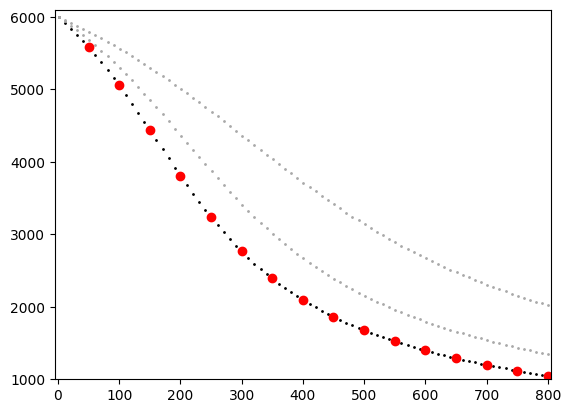

In [11]:
# Successfully replicated results
plt.ylim(1000, 6100)
plt.xlim(-5, 805)
plt.scatter(y=y_1, x=x, color="black", s=1)
plt.scatter(y=y_1_5, x=x, color="darkgray", s=1)
plt.scatter(y=y_2, x=x, color="darkgray", s=1)
plt.scatter(y=data[1, :], x=data[0, :], color="red");

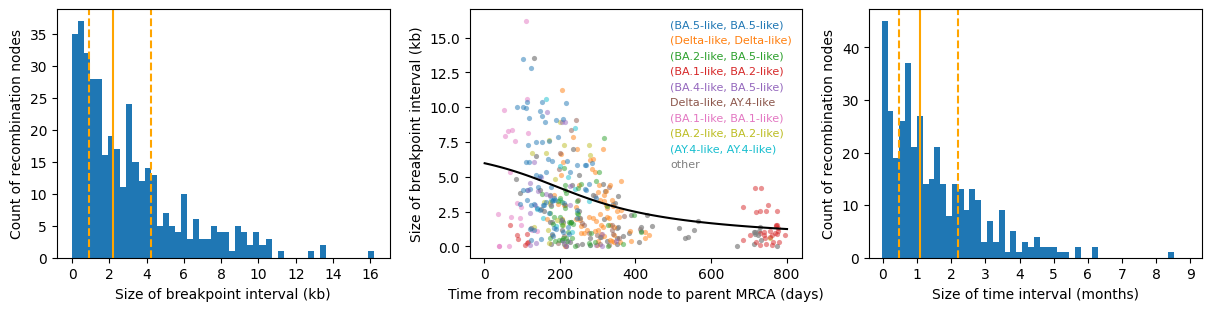

In [12]:
import matplotlib.patches as mpatches


int_size = (df_hq.interval_right - df_hq.interval_left) / 1000
time_re_mrca = ts.nodes_time[df_hq.mrca] - ts.nodes_time[df_hq.recombinant]

fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.05)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Distribution of size of breakpoint interval
ax0.set_ylabel("Count of recombination nodes")
ax0.set_xlabel("Size of breakpoint interval (kb)")
ax0.set_xticks(np.arange(0, 18, 2), labels=np.arange(0, 18, 2))
for q in [1/4, 1/2, 3/4]:
    ls = "solid" if q == 1/2 else "--"
    ax0.axvline(np.quantile(int_size, q), linestyle=ls, color="orange")
ax0.hist(int_size, bins=50)

# Trade-off between breakpoint interval size and RE-parent MRCA time
ax1.set_ylabel("Size of breakpoint interval (kb)")
ax1.set_xlabel("Time from recombination node to parent MRCA (days)")
other_pairs = {"color": "gray", "abbrev": "other"}
for i, row in enumerate(df_hq.itertuples()):
    scorpio_pair = frozenset([row.parent_left_scorpio, row.parent_right_scorpio])
    color = label_map.get(scorpio_pair, other_pairs)["color"]
    alpha = 0.5 if color != other_pairs["color"] else 0.7
    ax1.scatter(
        y=int_size[i],
        x=time_re_mrca[i],
        s=14,
        linewidths=0,
        color=color,
        alpha=alpha,
    )

assert ts.sequence_length - 1 == 29903
x = np.arange(1, 802, 10)
y = np.zeros(len(x), dtype=np.float32)
# https://www.nature.com/articles/s41579-023-00878-2
# No significant difference between non-VoCs and inside VoCs
# ~2 × 10–6 per site per day
L = 29903
mu = (2 * 1e-6) * L
for i in range(len(x)):
    y[i] = calc_expected_interval_size(x[i], mu=mu, L=L)
ax1.plot(x, y/1000, color="black")

empty_patch = mpatches.Patch(color='none', label='')
ax1.legend(
    labels=[label_map[k]["abbrev"] for k in label_map.keys()] + ["other"],
    labelcolor=list([label_map[k]["color"] for k in label_map.keys()]) + [other_pairs["color"]],
    handles=[empty_patch for _ in range(len(label_map) + 1)],
    fontsize=8,
    frameon=False,
)

# Distribution of size of time interval
ax2.set_ylabel("Count of recombination nodes")
ax2.set_xlabel("Size of time interval (months)")
label_days = np.arange(1, 265, 27)
ax2.set_xticks(label_days, labels=np.arange(len(label_days)))
ax2.set_xlim(-10, 253)
for q in [1/4, 1/2, 3/4]:
    ls = "solid" if q == 1/2 else "--"
    ax2.axvline(np.quantile(time_diffs, q), linestyle=ls, color="orange")
ax2.hist(time_diffs, bins=50);